# Symulacja ciągów pseudolosowych, ich filtracja i analiza
1. Symulować szum biały o rozkładzie normlanym N(5, 0.1).
2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną.
3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach.
4. Obliczyć gęstość prawdopodobieństwa, dystrybuantę, a też wartość oczekiwaną, wariancję i funkcję kowariancyjną sygnału wyjściowego. Porównać wyniki z p 2.
Wyniki przedstawiać w postaci tablic oraz wykresów

# Literatura
1. Snopkowski R. Symulacja stochastyczna AGH, Kraków, 2007.
2. Niemiro W. Symulacje stochastyczne i metody Monte Carlo, Uniw. Warszawski, 2013.
3. Cacho K., Bily M., Bukowski J. Random processs, analysis and simulation, 1988
4. Othes R.K., Enochson Analiza numeryczna szeregów czasowych, WNT, Warszawa, 1988

-----------------------------------------

## Importowanie potrzebnych bibliotek

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, describe
from scipy import signal
import pandas  as pd

## 1. Symulacja szumu białego o rozkładzie normlanym N(5, 0.1).
### Wytworzenie szumu białego o rozkładzie Gassowskim

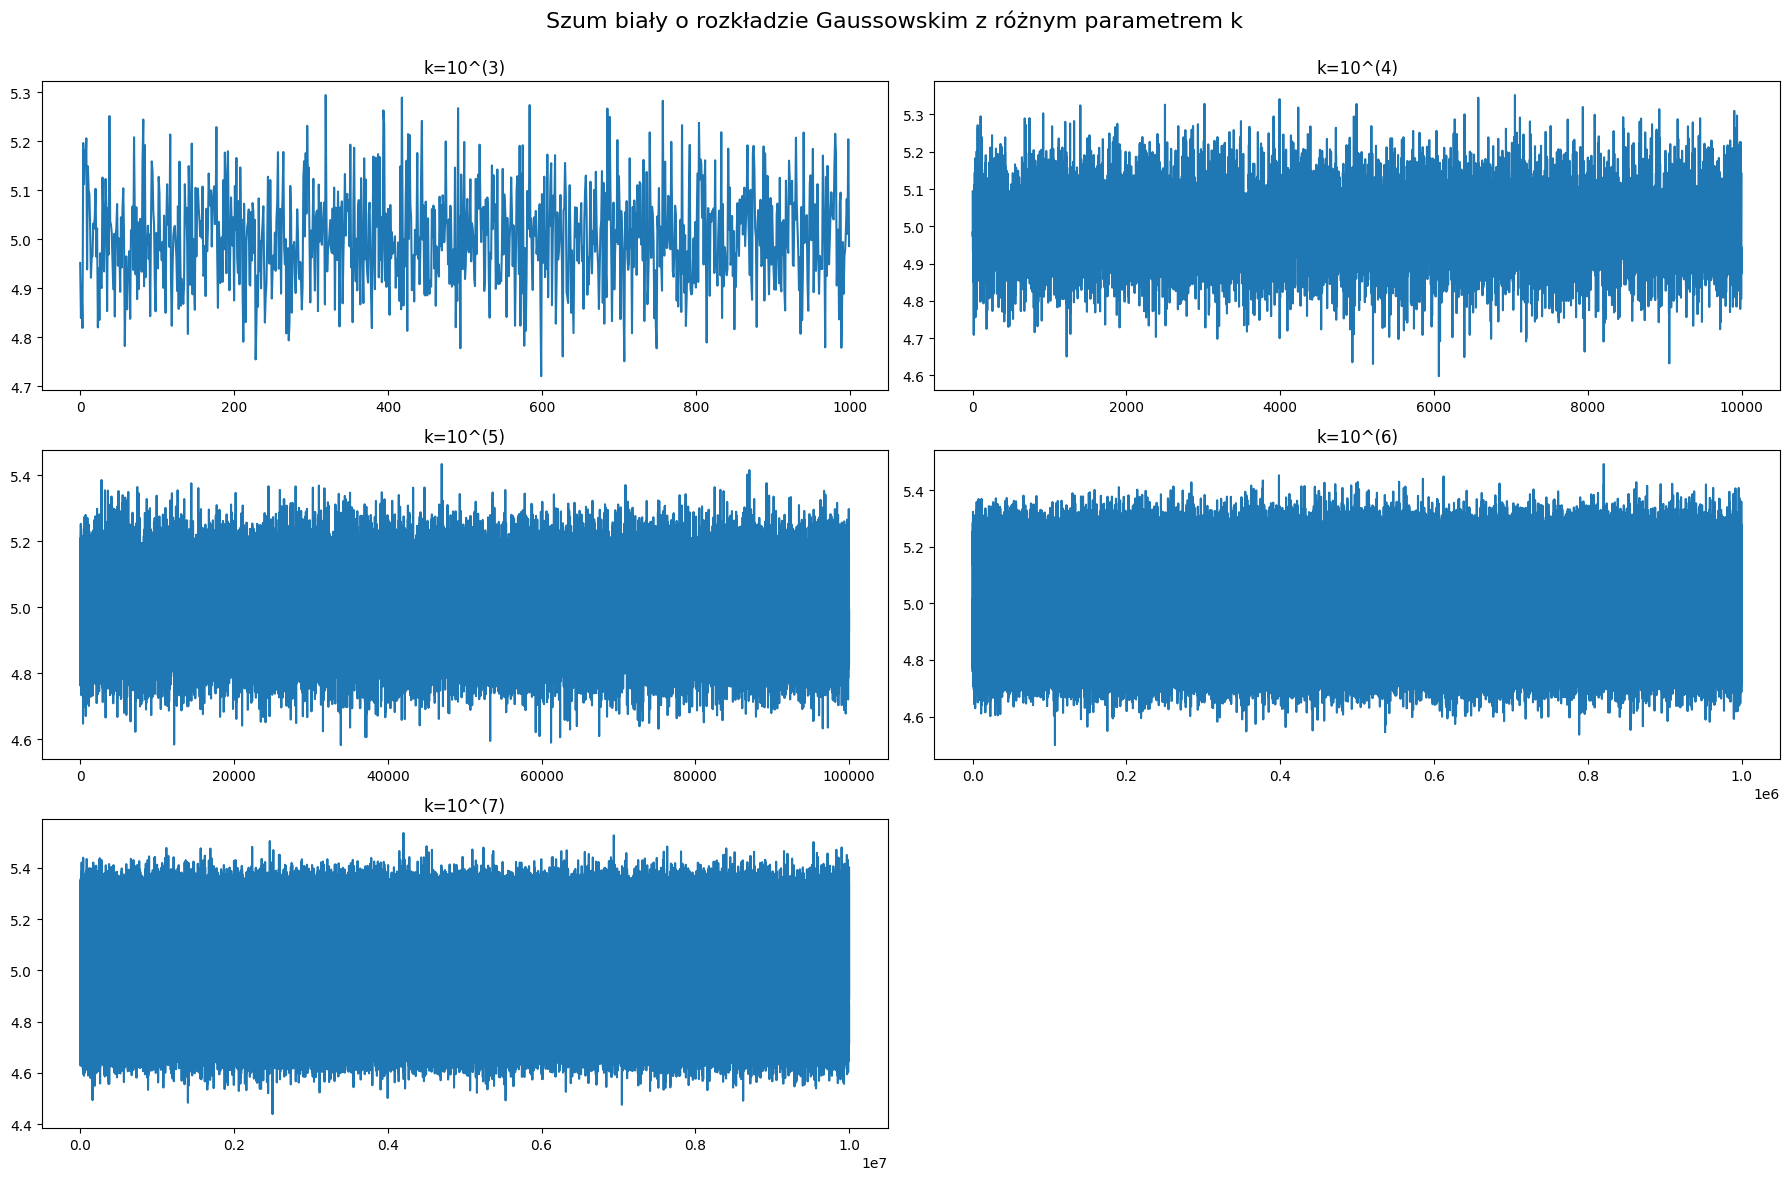

In [47]:
#Default parameters to describe white noise
mu = 5
sigma = 0.1
k_1 = pow(10,3)     #Amount of samples to generate white noise
k_2 = pow(10,4)
k_3 = pow(10,5)
k_4 = pow(10,6)
k_5 = pow(10,7)

samples_k_1 = np.random.normal(mu, sigma, size=k_1)
samples_k_2 = np.random.normal(mu, sigma, size=k_2)
samples_k_3 = np.random.normal(mu, sigma, size=k_3)
samples_k_4 = np.random.normal(mu, sigma, size=k_4)
samples_k_5 = np.random.normal(mu, sigma, size=k_5)

fig, axarr = plt.subplots(3, 2)
fig.set_figheight(12)
fig.set_figwidth(18)
fig.suptitle("Szum biały o rozkładzie Gaussowskim z różnym parametrem k", fontsize=16)

axarr[0, 0].plot(samples_k_1)
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(samples_k_2)
axarr[0, 1].set_title('k=10^(4)')
axarr[1, 0].plot(samples_k_3)
axarr[1, 0].set_title('k=10^(5)')
axarr[1, 1].plot(samples_k_4)
axarr[1, 1].set_title('k=10^(6)')
axarr[2, 0].plot(samples_k_5)
axarr[2, 0].set_title('k=10^(7)')
axarr[2, 1].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

Powyższy wygenerowany diagram prezentuje szum biały składającego się z określonej liczby próbek zadeklarowanej w zmiennej <font color=yellow>samples_k{i}</font>. Szum biały jest rodzajem szumu akustycznego, który posiada całkowicie płaskie widmo. W procesie stochastycznym szum biały to ciąg nieskorelowanych zmiennych losowych o zerowej wartości oczekiwanej i stałej wariancji(czyli biały szum to proces kowariancyjnie stacjonarny) oraz w sensie ścisłym to biały szum w którym nieskorelowanie wzmianiamy do niezależności. Biały szum jest tak zwaną ,,cegiełką" podczas konstrukcji procesów stochastycznych. 

### Wyświetlenie histogramu szumu białego o charakterze Gaussowskim dla róznych k

In [48]:
def display_hist(samples, k):
    delta_x_1=1
    delta_x_2=0.6
    delta_x_3=0.3
    delta_x_4=0.1

    fig, axarr = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(12)
    fig.suptitle("Histogram szumu białego z różną wartością Δx dla k={}".format(k), fontsize=16)

    axarr[0, 0].hist(samples, bins=int(6/delta_x_1))
    axarr[0, 0].set_title('Δx=1')
    axarr[0, 1].hist(samples, bins=int(6/delta_x_2))
    axarr[0, 1].set_title('Δx=0,6')
    axarr[1, 0].hist(samples, bins=int(6/delta_x_3))
    axarr[1, 0].set_title('Δx=0,3')
    axarr[1, 1].hist(samples, bins=int(6/delta_x_4))
    axarr[1, 1].set_title('Δx=0,1')

    # Tight layout often produces nice results
    # but requires the title to be spaced accordingly
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)

    plt.show()

#### k=10^(3)

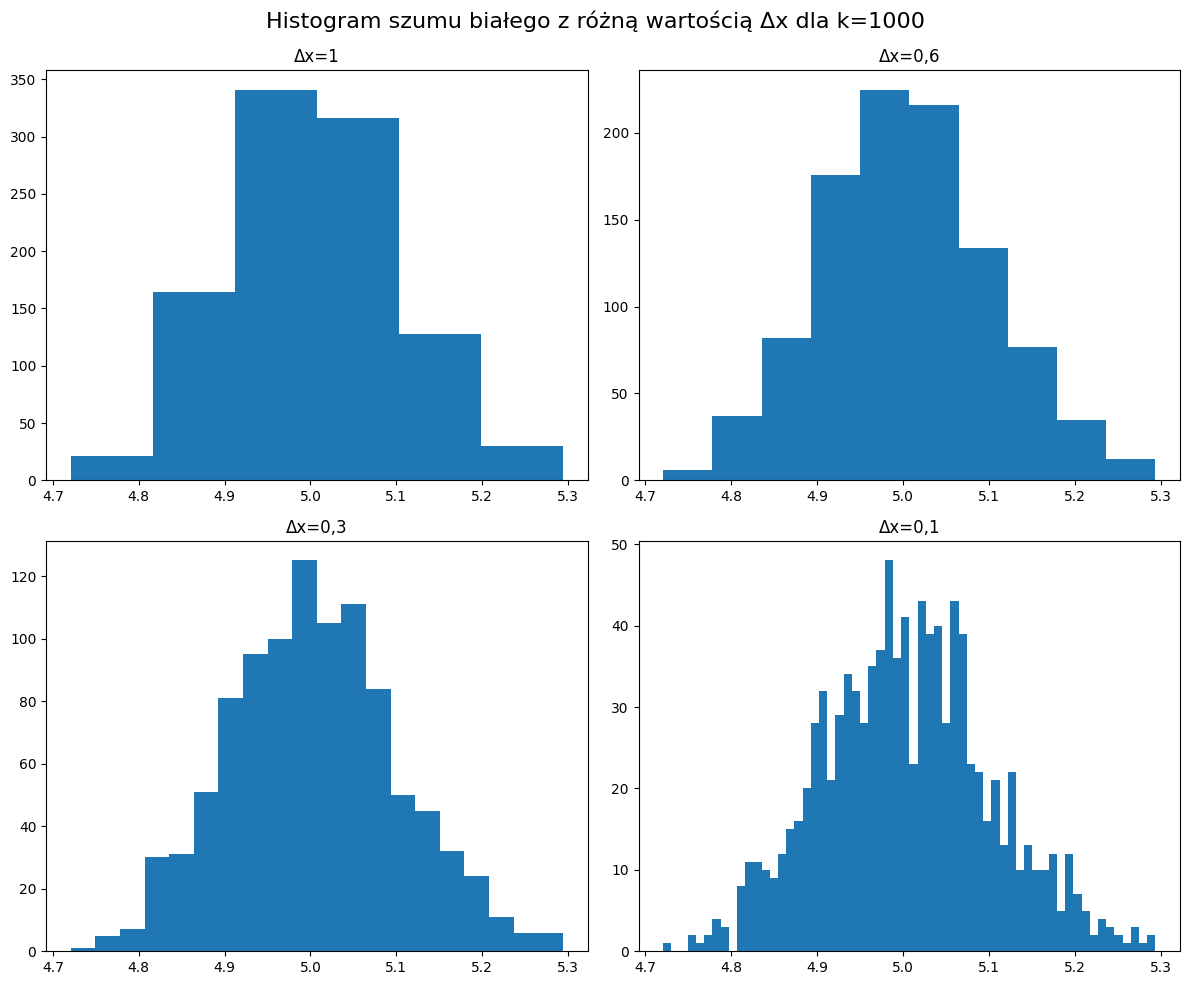

In [49]:
display_hist(samples_k_1, k_1)

#### k=10^(4)

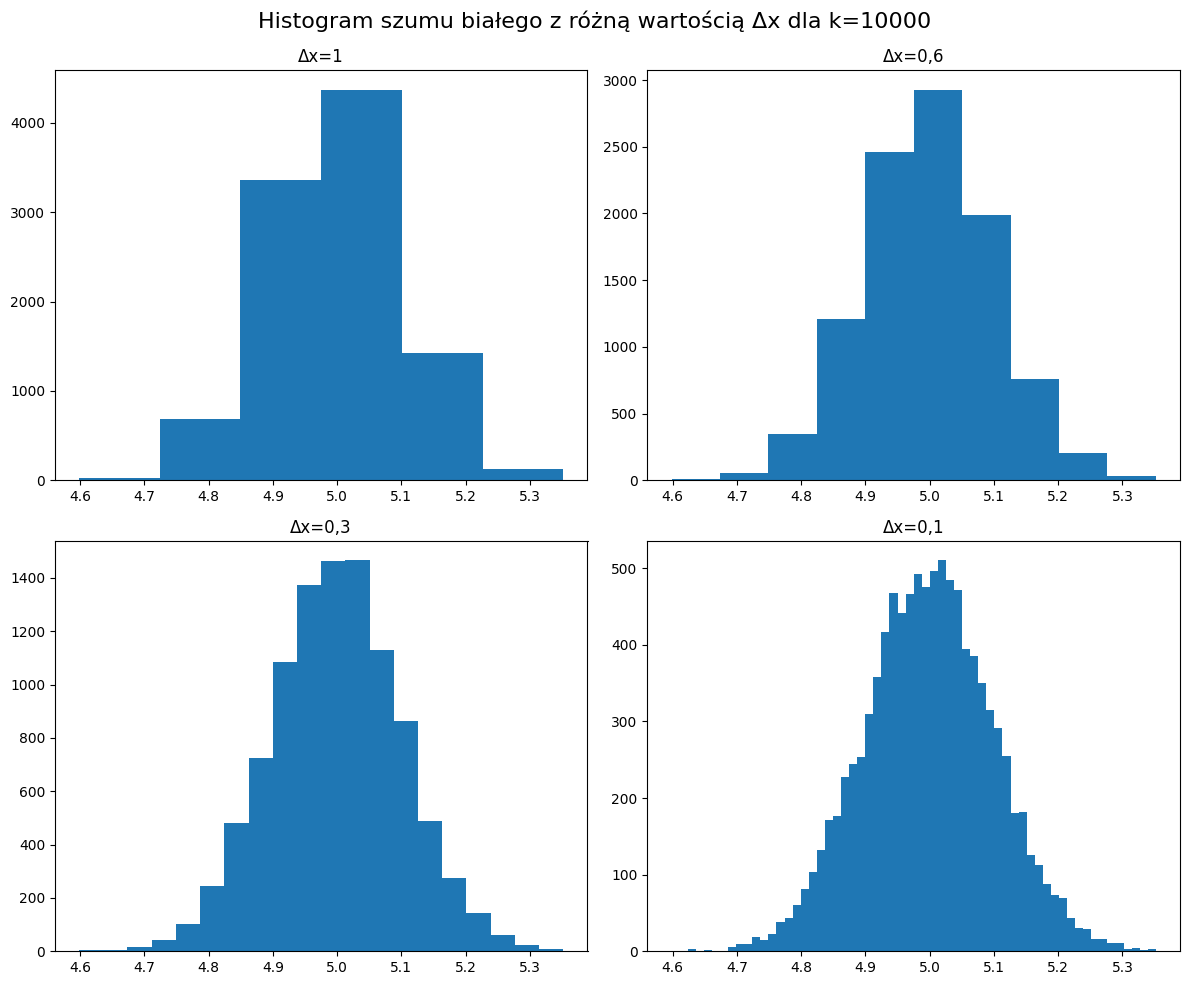

In [50]:
display_hist(samples_k_2, k_2)

#### k=10^(5)

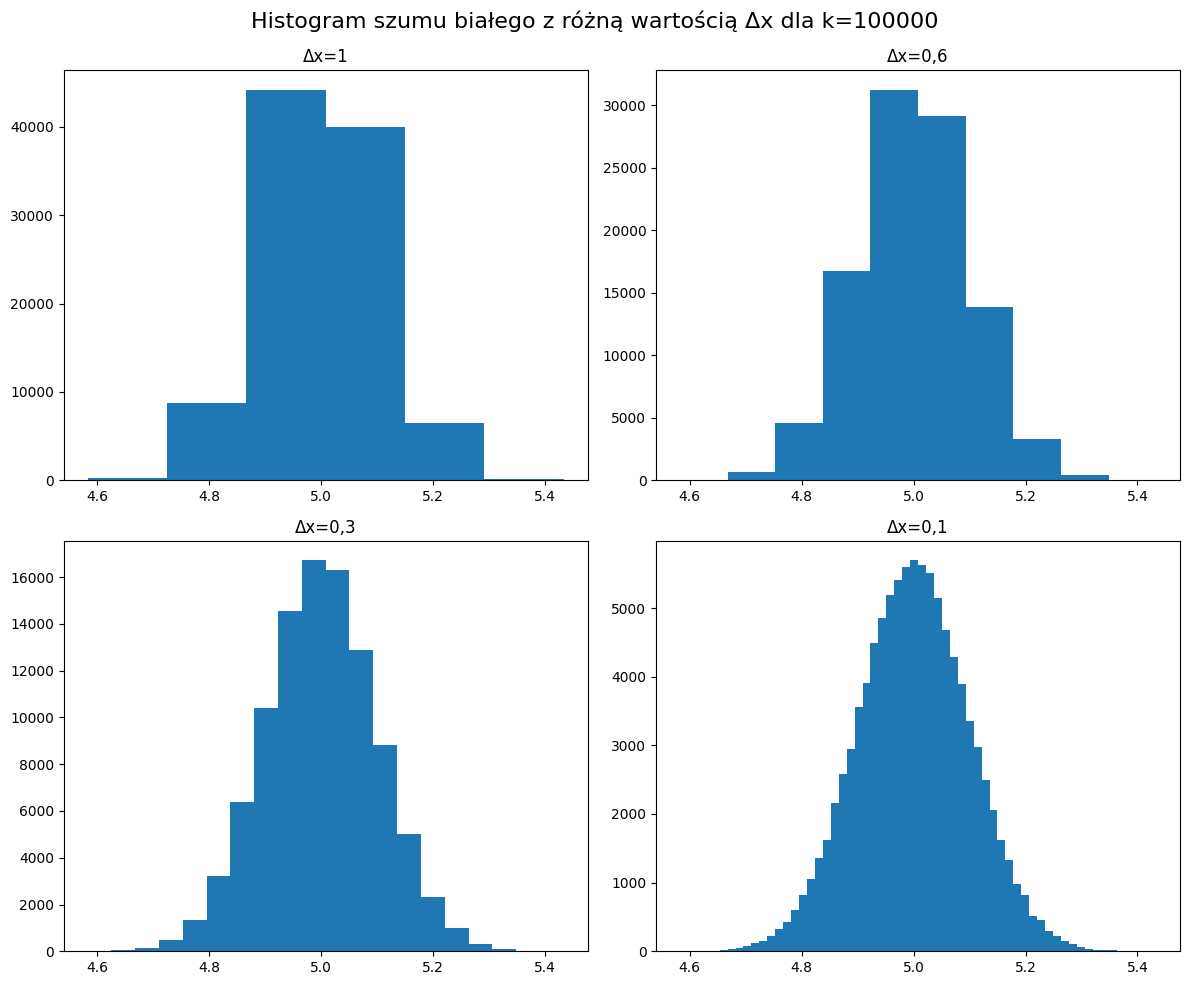

In [51]:
display_hist(samples_k_3, k_3)

####  k=10^(6)

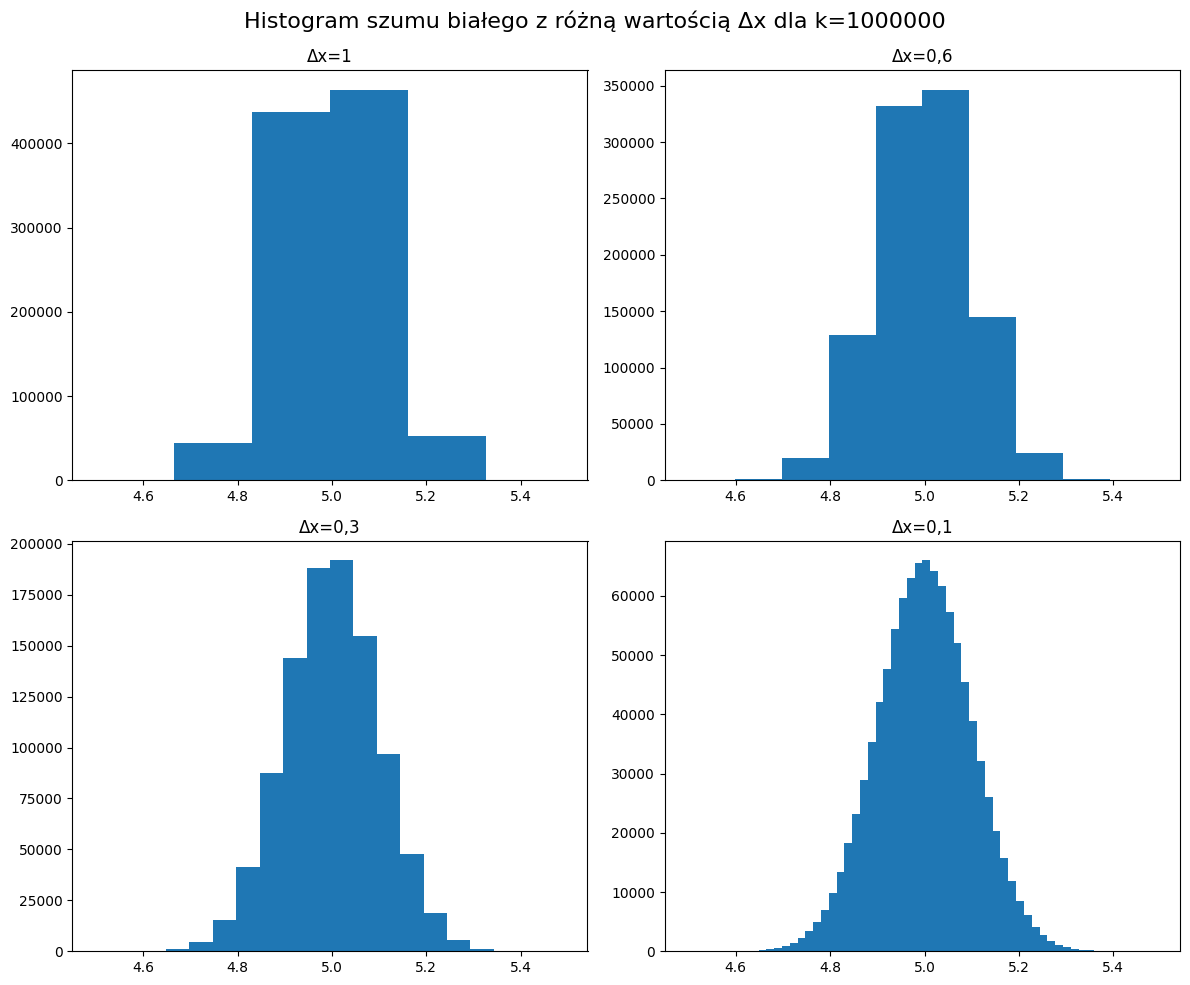

In [52]:
display_hist(samples_k_4, k_4)

#### k=10^(7)

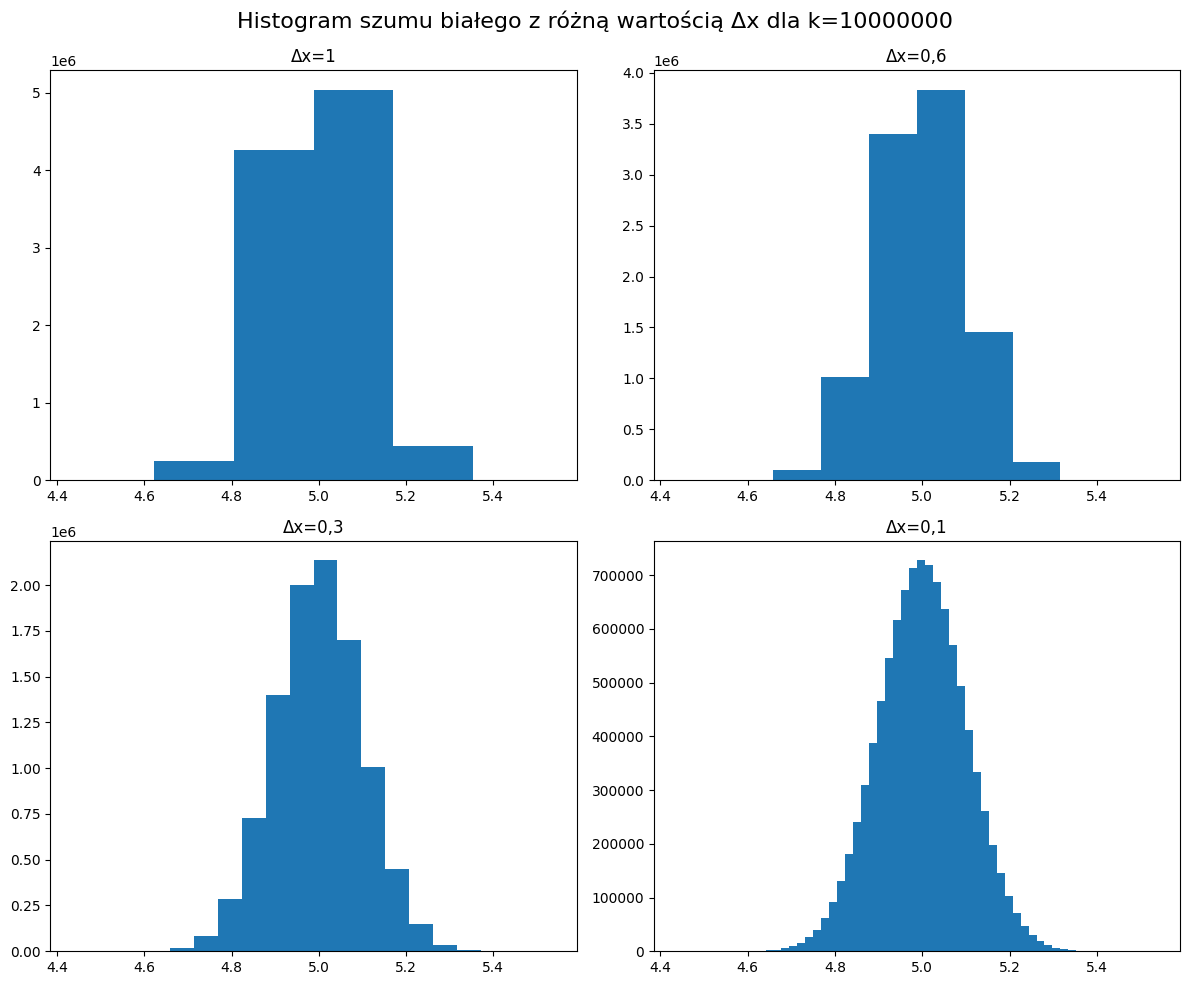

In [53]:
display_hist(samples_k_5, k_5)

## 2. Na podstawie otrzymanego ciągu obliczyć gęstość prawdopodobieństwta, dystrybuantę, a też wartość oczekiwan, wariancję i funkcję kowariancyjną.

### Obliczenie gęstości prawdopodobieństwa

<b>Gęstość prawdopodobieństwa</b> (ang. probability density function) to funkcja, która opisuje rozkład prawdopodobieństwa zmiennej losowej X. Gęstość prawdopodobieństwa może być używana do obliczenia prawdopodobieństwa wystąpienia wartości zmiennej losowej w określonym przedziale. W przeciwieństwie do dystrybuanty, gęstość prawdopodobieństwa nie jest równa prawdopodobieństwu, lecz określa szybkość zmian prawdopodobieństwa zmiennej losowej wokół danej wartości.

$$ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

<font color=red>Uwaga aby wyświetlić gęstość prawdopodobieństwa należy posortować najpierw tablicę. Wytłumaczenie w linku poniżej</font>       
https://stackoverflow.com/questions/71296986/how-to-draw-the-probability-density-function-pdf-plot-in-python

In [54]:
def probability_pdf(samples):
    sort_samples = np.sort(samples)
    probability_pdf = norm.pdf(sort_samples, mu, sigma)
    return probability_pdf

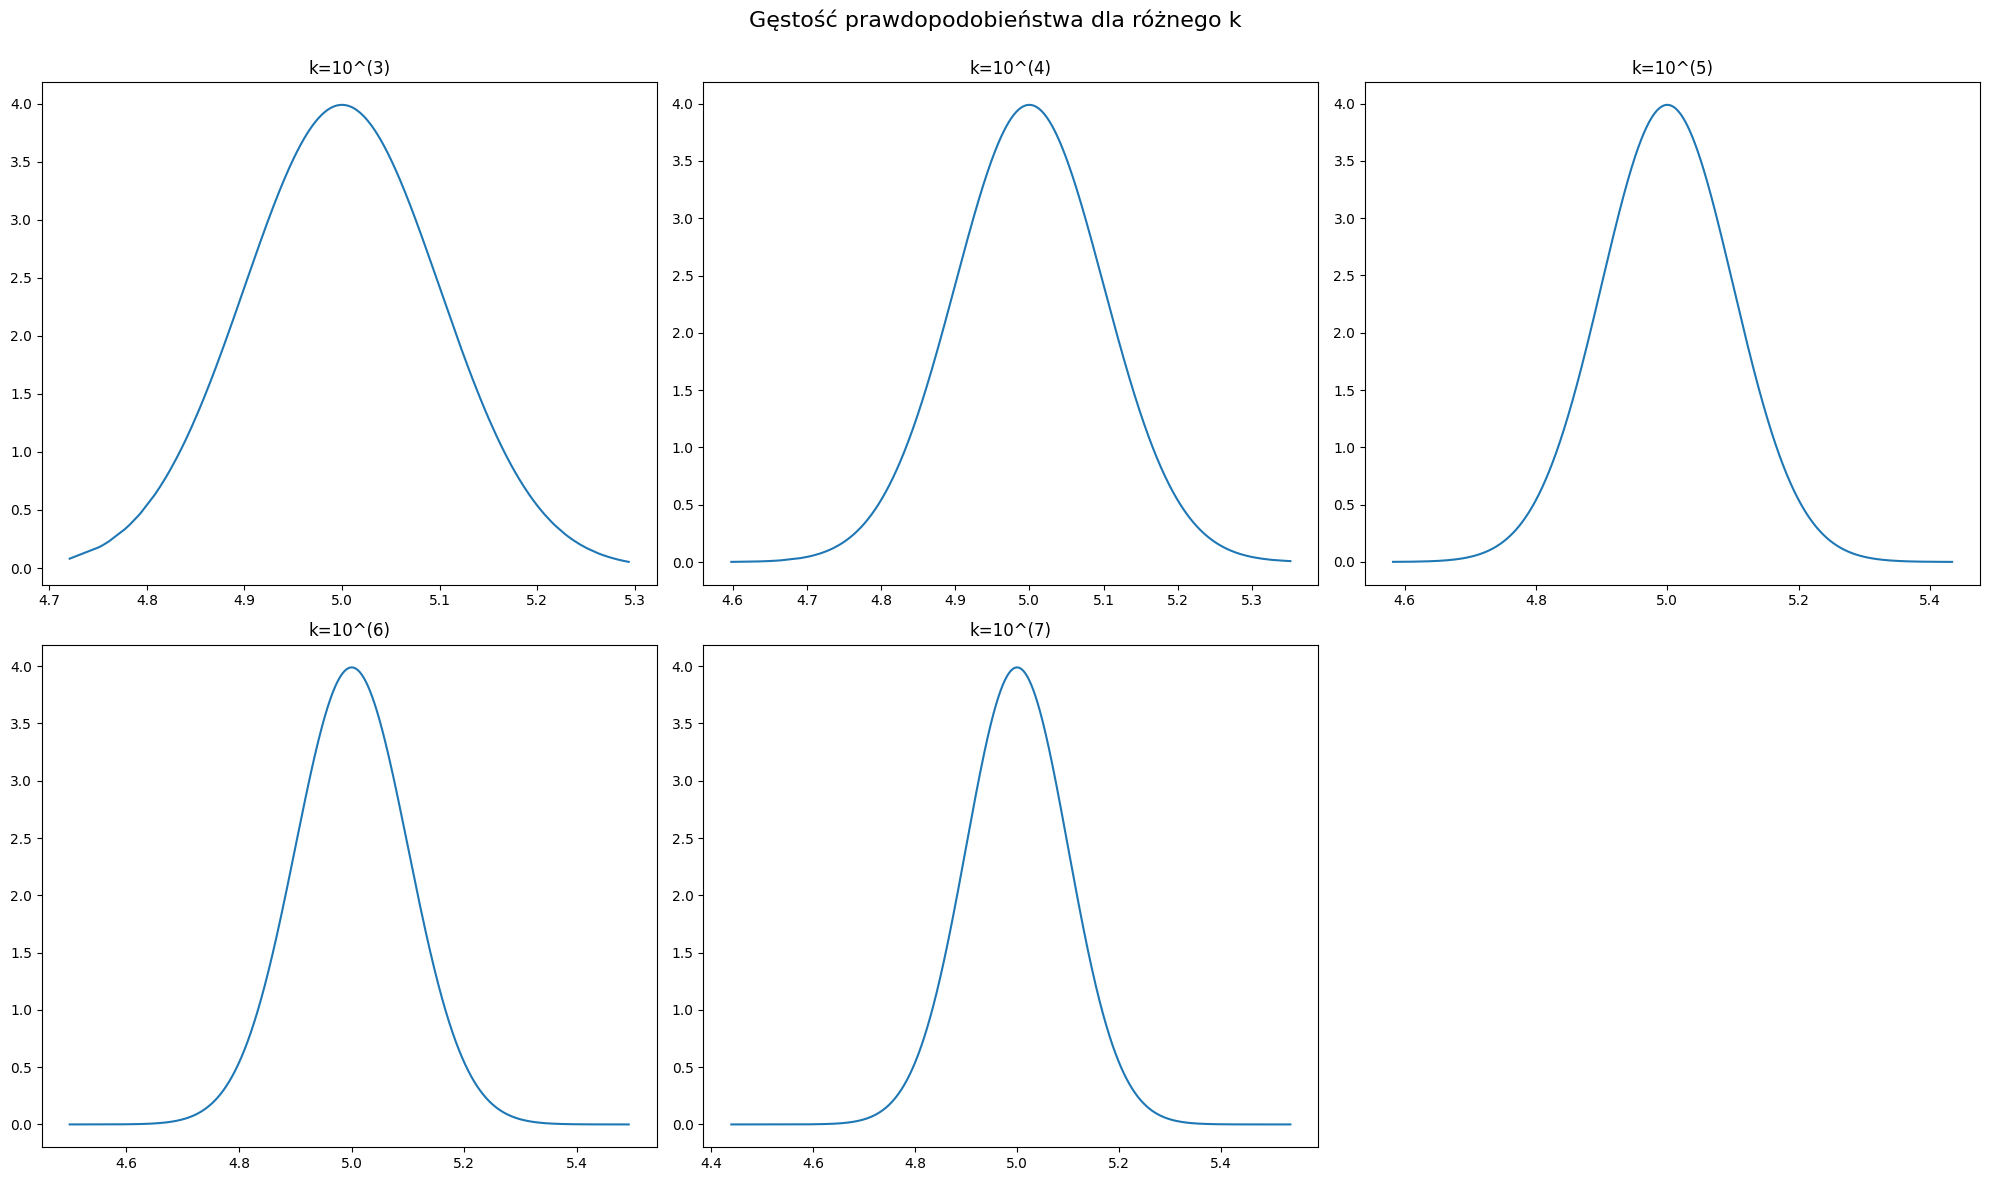

In [55]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Gęstość prawdopodobieństwa dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(samples_k_1), probability_pdf(samples_k_1))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(samples_k_2), probability_pdf(samples_k_2))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(samples_k_3), probability_pdf(samples_k_3))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(samples_k_4), probability_pdf(samples_k_4))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(samples_k_5), probability_pdf(samples_k_5))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie dystrybuanty

<b>Dystrybuanta</b> - (ang. cumulative distribution function) to funkcja matematyczna, która określa prawdopodobieństwo, że losowo wybrana zmienna losowa X jest mniejsza lub równa danej wartości x, tzn. F(x) = P(X ≤ x). Dystrybuanta może być użyta do określenia takich wartości jak kwantyle (np. mediana) oraz do badania asymetrii i ogona rozkładu zmiennej losowej.

$$ F(x) = \frac{1}{2}\left[1 + \operatorname{erf}\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right] $$

Podobnie jak dla obliczenia gęstości prawdopodobieństwa najpierw należało skorzystać z posortowanych wcześniej danych w tablicy <font color=yellow>samples</font>
https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python

In [56]:
def norm_cdf(samples):
    sort_samples = np.sort(samples)
    norm_cdf = norm.cdf(sort_samples, mu, sigma)
    return norm_cdf

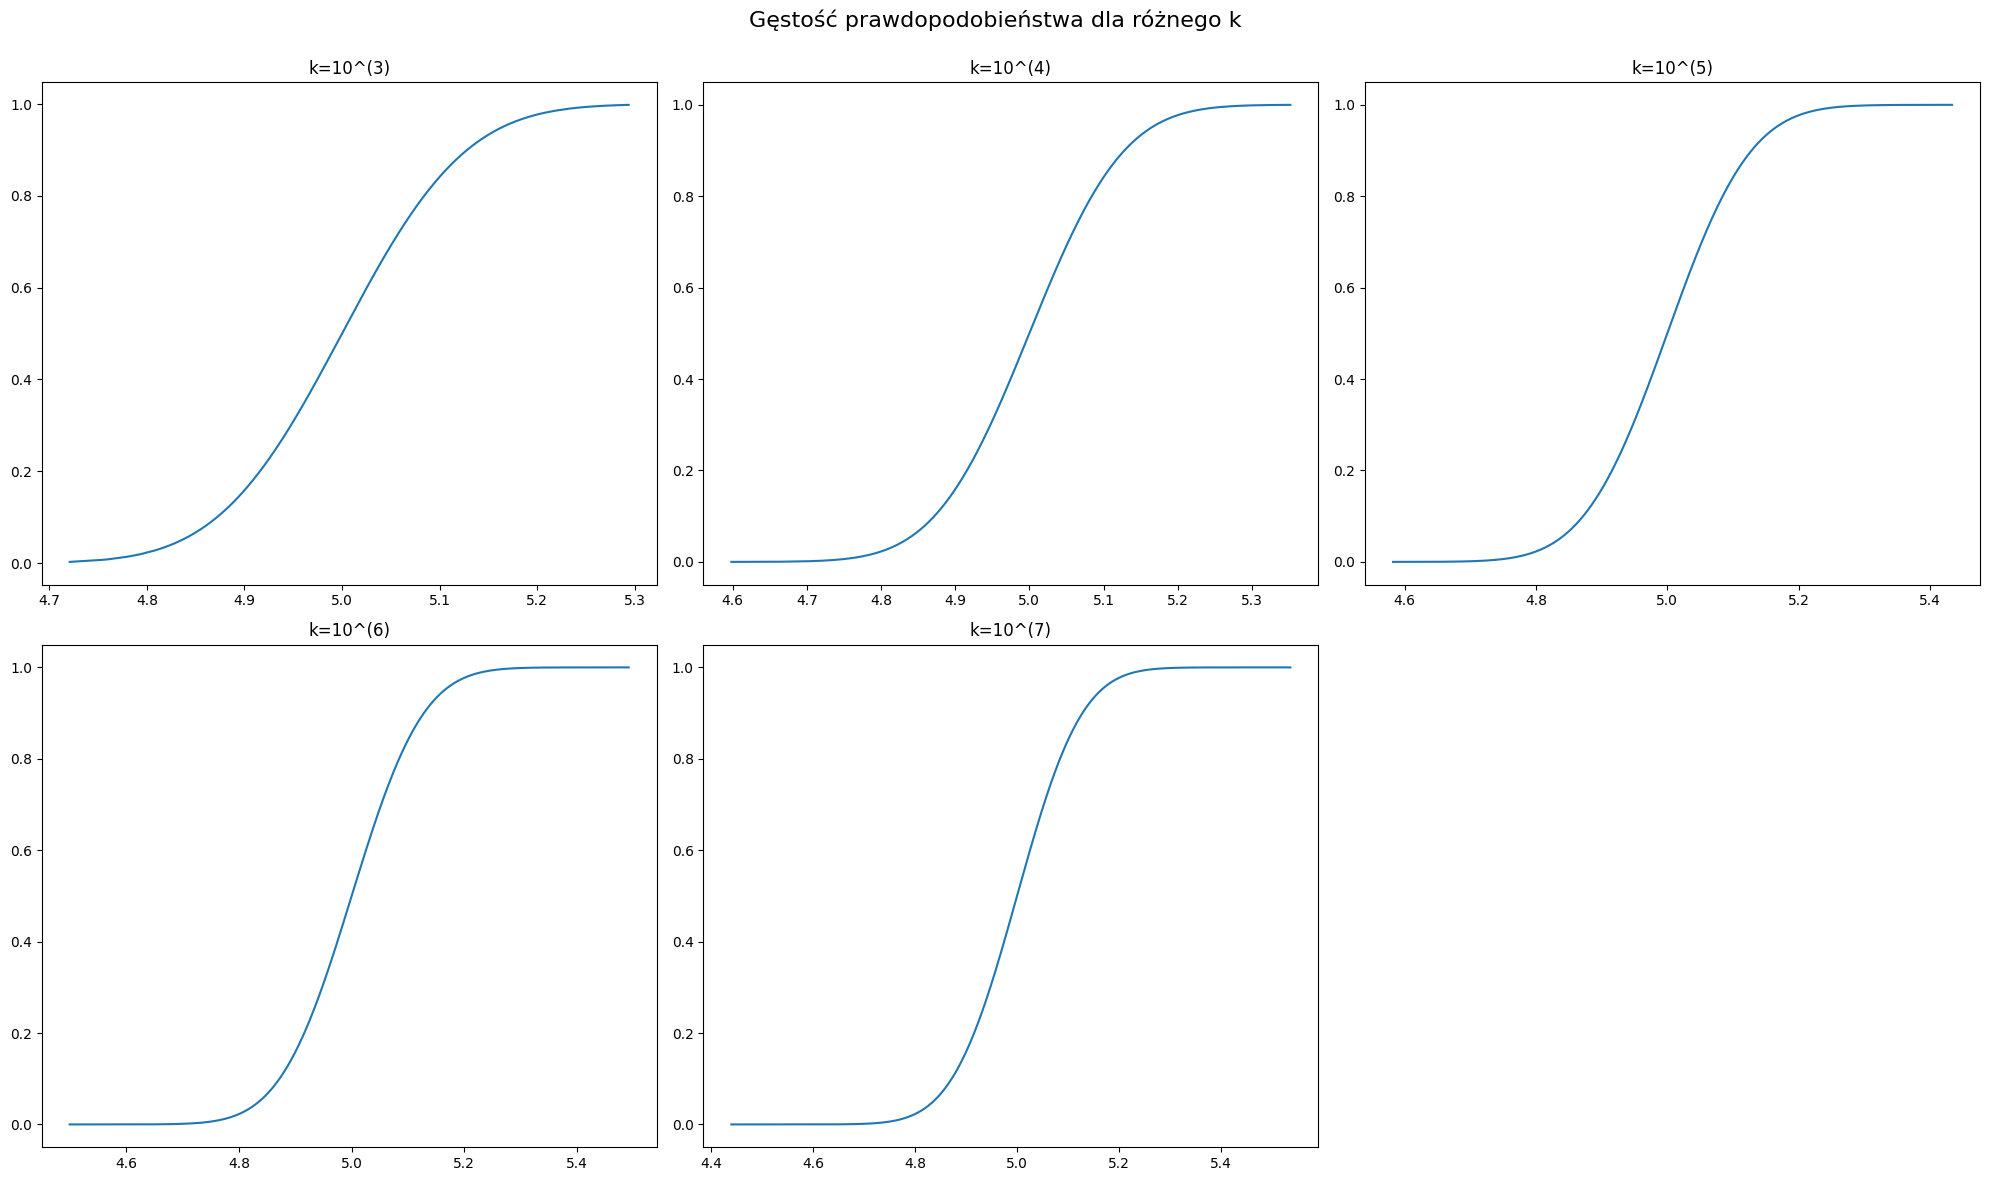

In [57]:
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle("Gęstość prawdopodobieństwa dla różnego k", fontsize=16)

axarr[0, 0].plot(np.sort(samples_k_1), norm_cdf(samples_k_1))
axarr[0, 0].set_title('k=10^(3)')
axarr[0, 1].plot(np.sort(samples_k_2), norm_cdf(samples_k_2))
axarr[0, 1].set_title('k=10^(4)')
axarr[0, 2].plot(np.sort(samples_k_3), norm_cdf(samples_k_3))
axarr[0, 2].set_title('k=10^(5)')
axarr[1, 0].plot(np.sort(samples_k_4), norm_cdf(samples_k_4))
axarr[1, 0].set_title('k=10^(6)')
axarr[1, 1].plot(np.sort(samples_k_5), norm_cdf(samples_k_5))
axarr[1, 1].set_title('k=10^(7)')
axarr[1, 2].set_visible(False)

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

### Obliczenie wartości oczekiwanej

<b>Wartość oczekiwana</b> - (ang. expected value) to średnia wartość zmiennej losowej X. Można ją wyznaczyć przez pomnożenie każdej wartości zmiennej losowej przez jej prawdopodobieństwo i zsumowanie tych wartości. Wartość oczekiwana jest jednym z najważniejszych parametrów opisujących zmienną losową, ponieważ pozwala na określenie, jakiej wartości można oczekiwać, gdy zmienna losowa zostanie wielokrotnie pomierzona.

$$ E(X) = \int_{-\infty}^{\infty} x f(x) dx $$

Wytłumaczone na filmiku jak w pythonie obliczać wartość oczekiwaną oraz wariancję
https://www.youtube.com/watch?v=ikcUBqELZVU

In [58]:
#Dla k=10^(3)
expected_value_k1 = describe(samples_k_1).mean
#Dla k=10^(4)
expected_value_k2 = describe(samples_k_2).mean
#Dla k=10^(5)
expected_value_k3 = describe(samples_k_3).mean
#Dla k=10^(6)
expected_value_k4 = describe(samples_k_4).mean
#Dla k=10^(7)
expected_value_k5 = describe(samples_k_5).mean

### Obliczenie wariancji

<b>Wariancja</b> - w procesach stochastycznych to miara zmienności losowej zmiennej w czasie. Jest to średnia arytmetyczna kwadratów odchyleń wartości losowej zmiennej od jej wartości oczekiwanej w ciągu określonego czasu. Innymi słowy, wariancja procesu stochastycznego mierzy, jak bardzo zmieniają się wartości zmiennej losowej w czasie, i określa, jak bardzo trajektoria procesu różni się od średniej trajektorii. Im większa wariancja, tym większa zmienność w trajektorii procesu, a tym samym większa szansa na wystąpienie dużych odchyleń od wartości oczekiwanej. Wariancja jest jednym z podstawowych parametrów charakteryzujących proces stochastyczny i jest istotnym narzędziem w analizie i modelowaniu procesów losowych. W praktyce, często używa się także odchylenia standardowego, które jest pierwiastkiem kwadratowym z wariancji i wyraża się w tych samych jednostkach co zmienna losowa.


$$ \operatorname{Var}(X) = E\left[(X - E(X))^2\right] = \int_{-\infty}^{\infty} (x - E(X))^2 f(x) dx $$

In [59]:
#Dla k=10^(3)
variance_k1 = describe(samples_k_1).variance
#Dla k=10^(4)
variance_k2 = describe(samples_k_2).variance
#Dla k=10^(5)
variance_k3 = describe(samples_k_3).variance
#Dla k=10^(6)
variance_k4 = describe(samples_k_4).variance
#Dla k=10^(7)
variance_k5 = describe(samples_k_5).variance

Podsumowanie obliczeń wartości oczekiwanej oraz kowariancji względem różnych k

In [60]:
dict = {'k' : ['k^(3)', 'k^(4)', 'k^(5)', 'k^(6)', 'k^(7)'],
        'wartość oczekiwana' : [expected_value_k1, expected_value_k2, expected_value_k3, expected_value_k4, expected_value_k5],
        'wariancja' : [variance_k1, variance_k2, variance_k3, variance_k4, variance_k5]}
df = pd.DataFrame(dict)

df.style

,k,wartość oczekiwana,wariancja
0,k^(3),5.004373,0.009741
1,k^(4),4.998548,0.010157
2,k^(5),4.999676,0.010006
3,k^(6),4.999902,0.010000
4,k^(7),4.999993,0.010000


### Obliczenie funkcji kowariancyjnej

<b>Funkcja kowariancyjna</b> - (ang. covariance function) to funkcja, która opisuje zależność między dwiema zmiennymi losowymi X i Y. Funkcja kowariancyjna określa, czy zmienne losowe X i Y są skorelowane (czy zmieniają się razem) lub niezależne (czy zmieniają się niezależnie od siebie). W przypadku zmiennych losowych niezależnych funkcja kowariancyjna wynosi 0, a w przypadku zmiennych losowych skorelowanych funkcja kowariancyjna może być dodatnia lub ujemna.

$$ \operatorname{Cov}(X_i, X_j) = \begin{cases} \sigma^2 & i = j \\ 0 & i \neq j \end{cases} $$

gdzie X_i i X_j to próbki szumu białego, a σ^2 to wariancja szumu białego.

In [61]:
def covariance(samples, k):
    # Subtitute DC component noise signal from samples
    subtitute_mu_value = samples - mu
    # Compute covariance function
    cov = np.correlate(subtitute_mu_value, subtitute_mu_value, mode='full') / k
    return cov

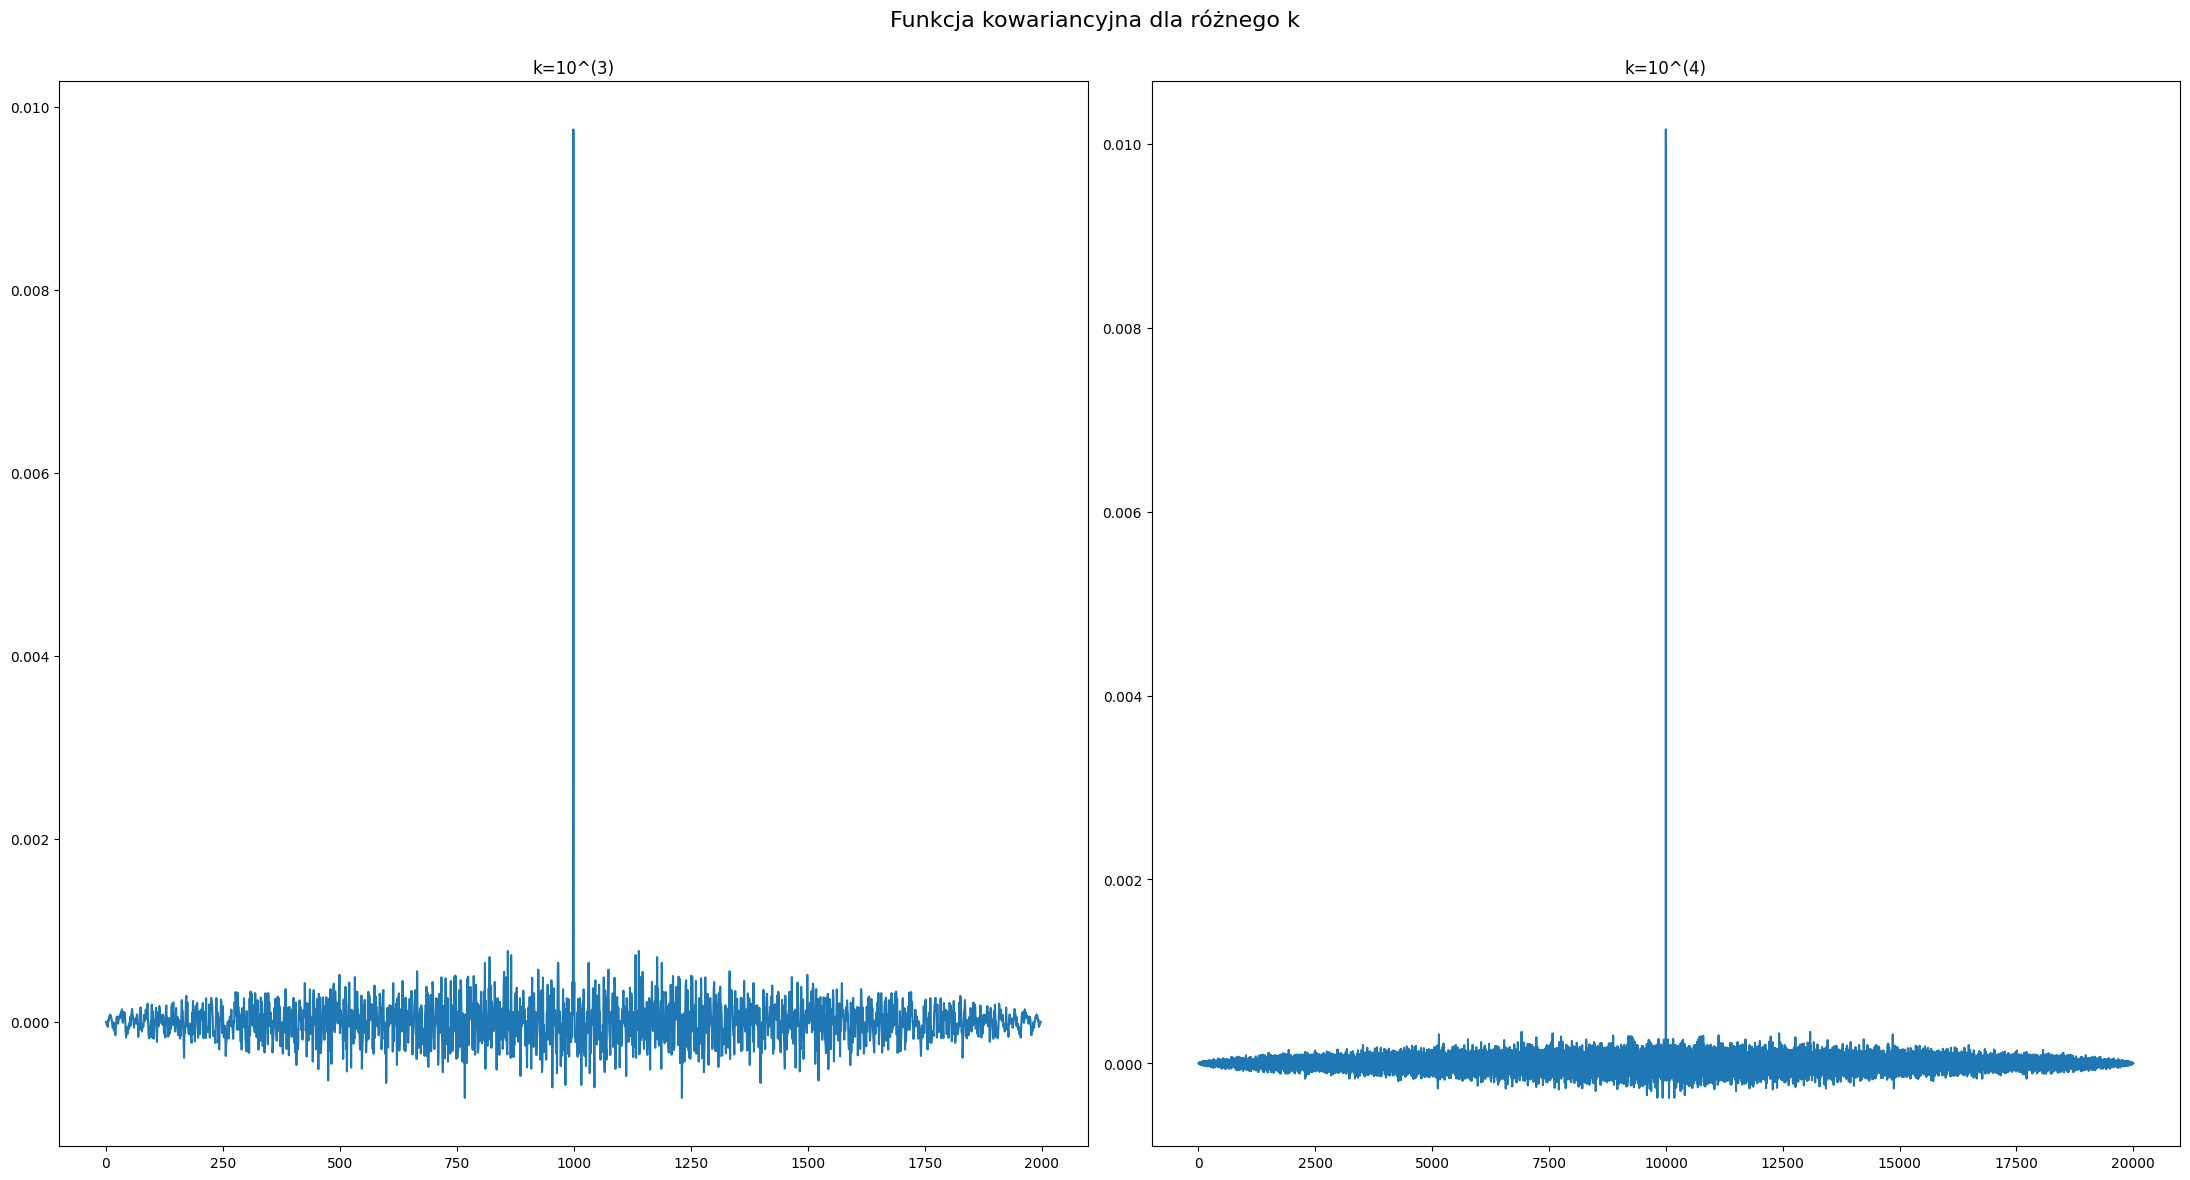

In [62]:
fig, axarr = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(22)
fig.suptitle("Funkcja kowariancyjna dla różnego k", fontsize=16)

axarr[0].plot(covariance(samples_k_1, k_1))
axarr[0].set_title('k=10^(3)')
axarr[1].plot(covariance(samples_k_2, k_2))
axarr[1].set_title('k=10^(4)')

# Tight layout often produces nice results
# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.show()

## 3. Przeprowadzić filtrację danych z wykorzystaniem filtru dolnoprzepustowego FIR (SOJ) o różnych parametrach

In [64]:
def filtration(samples_k_1, cutoff_param):
    # definicja filtra dolnoprzepustowego FIR (SOJ) o różnych parametrach
    filter1 = signal.firwin(numtaps=11, cutoff=cutoff_param, window='hamming', fs=5000)
    filter2 = signal.firwin(numtaps=31, cutoff=cutoff_param, window='hamming', fs=5000)
    filter3 = signal.firwin(numtaps=51, cutoff=cutoff_param, window='hamming', fs=5000)

    # przeprowadzenie filtracji danych z wykorzystaniem filtrów
    filtered1 = signal.convolve(samples_k_1, filter1, mode='same')
    filtered2 = signal.convolve(samples_k_1, filter2, mode='same')
    filtered3 = signal.convolve(samples_k_1, filter3, mode='same')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8))

    ax1.plot(samples_k_1)
    ax1.set_title("Szum biały")

    ax2.plot(filter1)
    ax2.set_title("Filtr dolnoprzepustowy FIR (SOJ) o 11 punktach")

    ax3.plot(filter2)
    ax3.set_title("Filtr dolnoprzepustowy FIR (SOJ) o 31 punktach")

    ax4.plot(filter3)
    ax4.set_title("Filtr dolnoprzepustowy FIR (SOJ) o 51 punktach")

    fig.tight_layout()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

    ax1.plot(samples_k_1, label='Szum biały')
    ax1.plot(filtered1, label='Filtr dolnoprzepustowy FIR (SOJ) o 11 punktach')
    ax1.legend()

    ax2.plot(samples_k_1, label='Szum biały')
    ax2.plot(filtered2, label='Filtr dolnoprzepustowy FIR (SOJ) o 31 punktach')
    ax2.legend()

    ax3.plot(samples_k_1, label='Szum biały')
    ax3.plot(filtered3, label='Filtr dolnoprzepustowy FIR (SOJ) o 51 punktach')
    ax3.legend()

    fig.tight_layout()
    plt.show()

#### Dla k=10^(3)

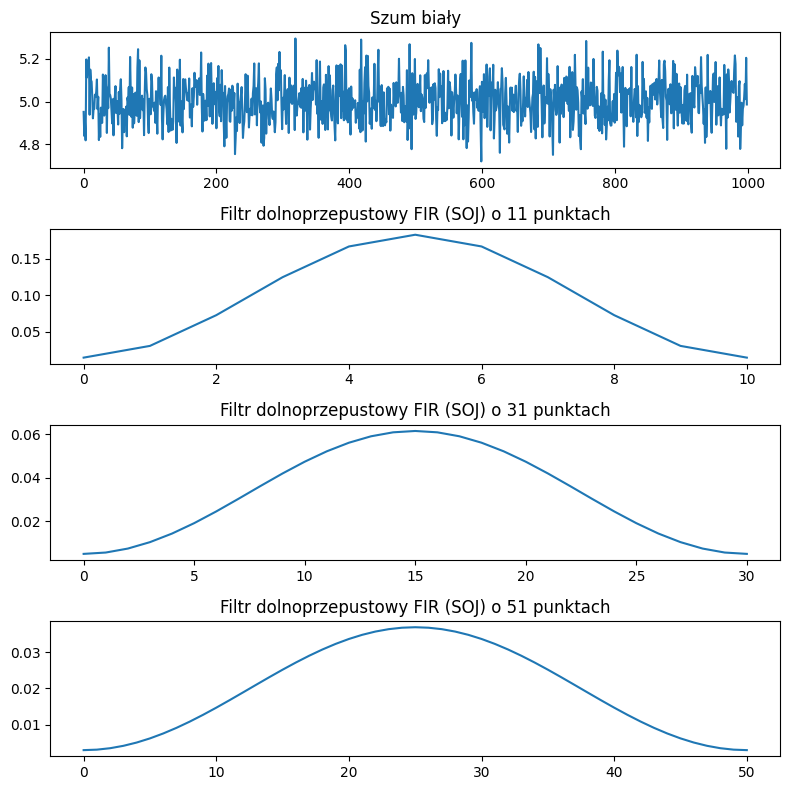

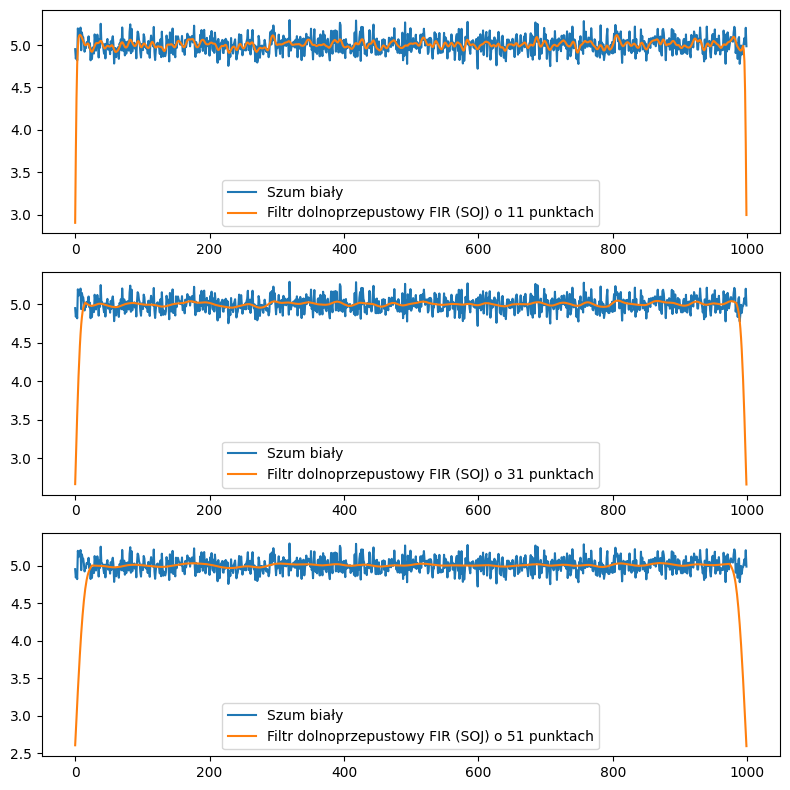

In [65]:
filtration(samples_k_1, 0.1)